In [ ]:
import os, sys, time
import pickle
import numpy as np
from Visa_Source_lib import *
import pyvisa as visa

import matplotlib.pyplot as plt

RECOrdlength = "5E6"

def get_time():
    gm_time = time.gmtime() 
    mk_time = time.mktime(gm_time)
    return str(int(mk_time))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def setup(add, SCALE=(80/400000) ): #str(0.5/396000)):
    rm = visa.ResourceManager()
    scope = rm.open_resource(add)
    scope.timeout = 80000 # ms
    scope.write('*cls') # clear ESR
    scope.write('FPAnel:PRESS DEFaultsetup')
    scope.write('FPAnel:PRESS MENUOff')
    #scope.write('SELECT:CH3 1')
    scope.write('SELECT:CH1 1')

    #scope.write('autoset EXECUTE')
    scope.write('HORizontal:RECOrdlength '+RECOrdlength )
    scope.write('DISPLAY:INTEnsITY:WAVEFORM 100')

    scope.write('TRIGger:A:EDGE:SOUrce CH1')
    scope.write('TRIGger:A:LEVel 1')
    scope.write('TRIGger:A:TYPe EDGe')
    scope.write('TRIGger:A:MODe NORMal')
    scope.write('TRIGger:A:EDGE:SLOpe FALL')

    #scope.write('CURSor:FUNCtion SCREEN')
    
    #scope.write('acquire:state 0')
    #scope.write('acquire:stopafter SEQUENCE') 
    #scope.write('acquire:state 1')
    scope.write('HORizontal:RECOrdlength '+RECOrdlength )
    scope.write('HORIZONTAL:DELay:TIME '+str(SCALE*4))
    scope.write('HORIZONTAL:SCALE '+str(SCALE))

    scope.write('CH1:POSition 0.5')
    #scope.write('CH3:POSition -2.5')
    
    scope.close()
    rm.close()


def get_rawdata(channel, visa_address ,SCALE=(80/400000), filename=""):
    rm = visa.ResourceManager()
    scope = rm.open_resource(visa_address)
    scope.timeout = 80000 # ms
    scope.encoding = 'latin_1'
    scope.read_termination = '\n'
    scope.write_termination = None

    #scope.write('*rst') # reset
    #t1 = time.perf_counter()
    #r = scope.query('*opc?') # sync
    #t2 = time.perf_counter()
    #print('reset time: {}'.format(t2 - t1))

    #scope.write('autoset EXECUTE') # autoset
    t3 = time.perf_counter()
    r = scope.query('*opc?') # sync
    t4 = time.perf_counter()
    #print('autoset time: {} s'.format(t4 - t3))

    scope.write('HORizontal:RECOrdlength '+ RECOrdlength )
    scope.write('HORizontal:SAMPLERate 100e5')
    scope.write('HORIZONTAL:SCALE '+str(SCALE))

    scope.write('header 0')
    scope.write('data:encdg SRIBINARY')
    scope.write('data:source '+channel) 
    scope.write('data:start 1')
    record = int(scope.query('horizontal:recordlength?'))
    scope.write('data:stop {}'.format(record)) 
    scope.write('wfmoutpre:byt_n 1') 

    scope.write('acquire:state 0')
    scope.write('acquire:stopafter SEQUENCE') 
    scope.write('acquire:state 1')

    #t5 = time.perf_counter()
    #r = scope.query('*opc?') # sync
    #t6 = time.perf_counter()
    #print('acquire time: {} s'.format(t6 - t5))

    # data query
    t7 = time.perf_counter()
    bin_wave = scope.query_binary_values('curve?', datatype='b', container=np.array, chunk_size =1024**2)
    t8 = time.perf_counter()
    print('transfer time: {} s'.format(t8 - t7))

    # retrieve scaling factors
    tscale = float(scope.query('wfmoutpre:xincr?'))
    tstart = float(scope.query('wfmoutpre:xzero?'))
    vscale = float(scope.query('wfmoutpre:ymult?')) # volts / level
    voff = float(scope.query('wfmoutpre:yzero?')) # reference voltage
    vpos = float(scope.query('wfmoutpre:yoff?')) # reference position (level)

    # error checking
    r = int(scope.query('*esr?'))
    print('event status register: 0b{:08b}'.format(r))
    r = scope.query('allev?').strip()
    print('all event messages: {}'.format(r))

    scope.close()
    rm.close()

    # create scaled vectors
    # horizontal (time)
    total_time = tscale * record
    tstop = tstart + total_time
    scaled_time = np.linspace(tstart, tstop, num=record, endpoint=False)
    # vertical (voltage)
    unscaled_wave = np.array(bin_wave, dtype='double') # data type conversion
    CLK_scaled_wave = (unscaled_wave - vpos) * vscale + voff
    #CLK_filename = [(idx, item) for idx,item in enumerate(CLK_scaled_wave, start=1)]
    print("find_nearest:", find_nearest(CLK_scaled_wave, 1.26))
    with open("pt_tmp/"+get_time()+"_"+channel+".txt", "wb") as fp:   #Pickling
        pickle.dump(CLK_scaled_wave, fp)

    #scaled_time = [(idx, item) for idx,item in enumerate(scaled_time, start=1)]
    with open("pt_tmp/"+get_time()+"_"+channel+"_time.txt", "wb") as fp:   #Pickling
        pickle.dump(scaled_time, fp)

    return CLK_scaled_wave, scaled_time



In [ ]:

#setup("USB0::0x0699::0x0405::C022392::INSTR", 1)
setup("USB0::0x0699::0x0405::C022392::INSTR", SCALE = 0.005)
CLK_scaled_wave, scaled_time = get_rawdata("1", "USB0::0x0699::0x0405::C022392::INSTR", SCALE = 0.005)
print(CLK_scaled_wave)
plt.plot(CLK_scaled_wave)
plt.show()

0.000648 0.92236 153.0 1e-07


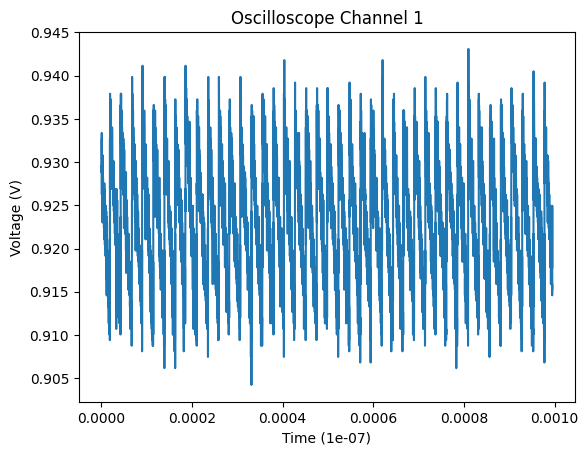

In [7]:
import pyvisa as visa
import numpy as np
from struct import unpack
import pylab

rm = visa.ResourceManager()
scope = rm.open_resource('USB0::0x0699::0x0405::C022392::INSTR')


scope.write('DATA:SOU CH1')
scope.write('DATA:WIDTH 1')
scope.write('DATA:ENC RPB')

ymult = float(scope.query('WFMPRE:YMULT?'))
yzero = float(scope.query('WFMPRE:YZERO?'))
yoff = float(scope.query('WFMPRE:YOFF?'))
xincr = float(scope.query('WFMPRE:XINCR?'))

print(ymult, yzero, yoff, xincr)


scope.write('CURVE?')
data_ch1 = scope.read_raw()
headerlen = 1 + int(data_ch1[1])
header = data_ch1[:headerlen]
ADC_wave_ch1 = data_ch1[headerlen:-1]


ADC_wave_ch1 = np.array(unpack('%sB' % len(ADC_wave_ch1),ADC_wave_ch1))
Volts_ch1 = (ADC_wave_ch1 - yoff) * ymult  + yzero
Time = np.arange(0, xincr * len(Volts_ch1), xincr)

#np.save('../np_tmp/ramp_1M_400us_0V.npy',[ADC_wave_ch1,Volts_ch1,Time]) 

pylab.title('Oscilloscope Channel 1')
pylab.ylabel('Voltage (V)')
pylab.xlabel('Time ('+ str(xincr) + ')')
pylab.plot(Time, Volts_ch1)
pylab.show()
rm.close()
scope.close()


In [ ]:

def find_timedif(Rawdata, Time):
    delta = 1
    avg = sum(Rawdata)/len(Rawdata)
    #print((avg)*delta)

    tmp = []
    for index, val in enumerate(Rawdata):
        if val >= (avg)*delta:
            tmp.append([index, val])

    pk2pk_time = []
    avg_dif_time = []
    for index, val in enumerate(tmp):
        if index < len(tmp)-1:
            #print(tmp[index+1][0] - val[0])
            time_dif = Time[tmp[index+1][0] ]- Time[val[0]]
            if (time_dif) >= 0.0002:
                #print(time_dif)
                pk2pk_time.append([time_dif, [val[0], val[1]], [tmp[index+1][0], tmp[index+1][1]]])
                avg_dif_time.append(time_dif)
    if avg_dif_time != []:
        avg_time = sum(avg_dif_time)/len(avg_dif_time)
    return pk2pk_time, avg_dif_time

In [ ]:
pk2pk_time = []
pk2pk_time, avg_time = find_timedif(Volts_ch1, Time)
print(len(pk2pk_time), avg_time)

In [ ]:
import matplotlib.pyplot as plt
for pk2pk_val in pk2pk_time:
    plt.scatter(pk2pk_val[1][0], pk2pk_val[1][1])
    plt.scatter(pk2pk_val[2][0], pk2pk_val[2][1])

plt.plot(Volts_ch1)
plt.show()

In [ ]:
wavfrom = np.load("../np_tmp/ramp_1M_400us_0V.npy")

print(wavfrom)

pylab.title('Oscilloscope Channel 1')
pylab.ylabel('Voltage (V)')
pylab.plot(wavfrom[2], wavfrom[1])
pylab.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#wavfrom = np.load("../np_tmp/ramp_1M_400us_0V.npy")
wavfrom = np.load("../np_tmp/noise_1M_1us.npy")

print(wavfrom)
# Number of samplepoints
N = 999953
T = (400E-6 * 10) / N
print(len(wavfrom[1]))
yf = np.fft.fft(wavfrom[1],axis=0)
freq=np.fft.fftfreq(np.size(wavfrom[1],0),T)
print(len(yf),xf)
plt.subplot(2, 1, 1)
plt.plot(wavfrom[1])
plt.subplot(2, 1, 2)
plt.plot(xf, np.abs(yf)[:])


In [ ]:
from scipy.fft import fft, fftfreq

wavfrom = np.load("../np_tmp/ramp_1M_400us_0V.npy")
SAMPLE_RATE = 1000000
# Number of samples in normalized_tone
N = SAMPLE_RATE * 400E-6*10/1E+6

yf = fft(wavfrom[1])
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
import pyvisa as visa
import numpy as np
from struct import unpack
import pylab

rm = visa.ResourceManager()
scope = rm.open_resource('USB0::0x0699::0x0405::C022392::INSTR')
scope.timeout = 10000
scope.write('DATA:SOU CH1')
scope.write('DATA:WIDTH 1')
scope.write('DATA:ENC RPB')

ymult = float(scope.query('WFMPRE:YMULT?'))
yzero = float(scope.query('WFMPRE:YZERO?'))
yoff = float(scope.query('WFMPRE:YOFF?'))
xincr = float(scope.query('WFMPRE:XINCR?'))

print(ymult, yzero, yoff, xincr)

scope.write('CURVE?')
data_ch1 = scope.read_raw()
headerlen = 1 + int(data_ch1[1])
header = data_ch1[:headerlen]
ADC_wave_ch1 = data_ch1[headerlen:-1]

print(len(ADC_wave_ch1))

ADC_wave_ch1 = np.array(unpack('%sB' % len(ADC_wave_ch1),ADC_wave_ch1))
pylab.plot(ADC_wave_ch1)
pylab.show()

In [ ]:
poin_list = []
data = []

In [ ]:
import time
import pyvisa as visa
import numpy as np
from struct import unpack
import pylab

horizontal_scale = 400E-3

rm = visa.ResourceManager()
scope = rm.open_resource('USB0::0x0699::0x0405::C022392::INSTR')
scope.timeout = 10000

scope.write('FPAnel:PRESS DEFaultsetup')
scope.write('FPAnel:PRESS MENUOff')
scope.write('HORizontal:RECOrdlength 10E+3')

time.sleep(2)
scope.write('AUTOSet EXECute')
time.sleep(2)

scope.write('CH1:BANdwidth 20E+6')
scope.write('TRIGger:A:EDGE:SOUrce CH1')
scope.write('TRIGger:A:TYPe EDGe')
scope.write('TRIGger:A:MODe AUTO')
scope.write('TRIGger:A:EDGE:COUPling DC')
scope.write('TRIGger:A:EDGE:SLOpe FALL')

for i in range(8):
    scope.write('MEASUrement:MEAS'+str(i+1)+':STATE OFF')

channel_list = [1,1,1,1,1]
MEASUrement_Type = ["MAXimum","MINImum","MEAN","FREQuency","pk2pk"]

for i in range(8):
    scope.write('MEASUrement:MEAS'+str(i+1)+':STATE OFF')
for i in range(len(MEASUrement_Type)):
    scope.write('MEASUrement:MEAS'+str(i+1)+':SOURCE1 CH'+str(channel_list[i]))
    scope.write('MEASUrement:MEAS'+str(i+1)+':TYPe '+ MEASUrement_Type[i])
    scope.write('MEASUrement:MEAS'+str(i+1)+':STATE ON')

time.sleep(5)
CH1_MEAN_VALue = scope.query('MEASUrement:MEAS3:VALue?')
print(CH1_MEAN_VALue)
scope.write('CH1:OFFSet '+CH1_MEAN_VALue)

for index in range(2):
    time.sleep(5)
    scope.write('ACQuire:STOPAfter SEQuence')
    #scope.write('acquire:state ON')
    time.sleep(5)
    CH1_MEAN_VALue = scope.query('MEASUrement:MEAS3:VALue?')
    CH1_AMPlitude_VALue = scope.query('MEASUrement:MEAS5:VALue?')
    print("CH1_MEAN_VALue : ", CH1_MEAN_VALue)
    scope.write('CH1:BANdwidth 20E+6')
    scope.write('CH1:OFFSet '+str(CH1_MEAN_VALue))
    scope.write('CH1:SCAle '+str(float(CH1_AMPlitude_VALue)/3))

scope.write('SELECT:MATH ON')
scope.write("MATH:TYPE FFT")

scope.write('CH1:POSition 1')
scope.write('HORIZONTAL:SCALE '+str(horizontal_scale))
scope.write('ACQuire:STOPAfter SEQuence')
scope.write('acquire:state ON')

time.sleep(3+horizontal_scale*20)
scope.write('DATA:SOU MATH')
scope.write('DATA:WIDTH 1')
scope.write('DATA:ENC RPB')

ymult = float(scope.query('WFMPRE:YMULT?'))
yzero = float(scope.query('WFMPRE:YZERO?'))
yoff = float(scope.query('WFMPRE:YOFF?'))
xincr = float(scope.query('WFMPRE:XINCR?'))

print(ymult, yzero, yoff, xincr)

scope.write('CURVE?')
data_ch1 = scope.read_raw()
headerlen = 8
#header = data_ch1[:headerlen]
ADC_wave_ch1 = data_ch1[headerlen:-1]
#ADC_wave_ch1 = data_ch1

ADC_wave_ch1 = np.array(unpack('%sB' % len(ADC_wave_ch1),ADC_wave_ch1))
Volts_ch1 = (ADC_wave_ch1 - yoff) * ymult  + yzero
Time = np.arange(0, xincr * len(Volts_ch1), xincr)
peakY = np.max(Volts_ch1)
locY = np.argmax(Volts_ch1)
frqY = Time[locY]
print(peakY, locY,frqY, frqY/(xincr * len(Volts_ch1)))

scope.write("MATH:VERTical:POSition 3")
scope.write("MATH:HORizontal:POSition {}".format(frqY/(xincr * len(Volts_ch1))*99))
scope.write("MATH:HORizontal:SCAle {}".format(frqY/20))

'''time.sleep(3)
ymult = float(scope.query('WFMPRE:YMULT?'))
yzero = float(scope.query('WFMPRE:YZERO?'))
yoff = float(scope.query('WFMPRE:YOFF?'))
xincr = float(scope.query('WFMPRE:XINCR?'))

print(ymult, yzero, yoff, xincr)

scope.write('CURVE?')
data_ch1 = scope.read_raw()
#headerlen = 1 + int(data_ch1[1])
#header = data_ch1[:headerlen]
#ADC_wave_ch1 = data_ch1[headerlen:-1]
ADC_wave_ch1 = data_ch1
ADC_wave_ch1 = np.array(unpack('%sB' % len(ADC_wave_ch1),ADC_wave_ch1))
Volts_ch1 = (ADC_wave_ch1 - yoff) * ymult  + yzero
Time = np.arange(0, xincr * len(Volts_ch1), xincr)
peakY = np.max(Volts_ch1)
locY = np.argmax(Volts_ch1)
frqY = Time[locY]'''

pylab.subplot(2,1,2)
pylab.title('Oscilloscope Math FFT', y=1)
pylab.ylabel('Voltage (dBV)')
if peakY >= -50:
    pylab.plot(frqY, peakY, 'r.', markersize=12)
    pylab.annotate(str(int(frqY))+" Hz",(frqY, peakY))

pylab.xlabel('Time ('+ str(xincr) + ')')
pylab.plot(Time, Volts_ch1,linewidth = 0.2,alpha = 0.8)
#pylab.plot(Volts_ch1)
pylab.yscale('log')
pylab.grid('on')

data.append([Volts_ch1, Time])
poin_list.append([frqY, peakY])

In [ ]:
import time
import pyvisa as visa
import numpy as np
from struct import unpack
import pylab

horizontal_scale = 400E-3

rm = visa.ResourceManager()
scope = rm.open_resource('USB0::0x0699::0x0405::C022392::INSTR')
scope.timeout = 10000


In [ ]:

scope.write('DATA:SOU CH1')
scope.write('DATA:WIDTH 1')
scope.write('DATA:ENC RPB')

ymult = float(scope.query('WFMPRE:YMULT?'))
yzero = float(scope.query('WFMPRE:YZERO?'))
yoff = float(scope.query('WFMPRE:YOFF?'))
xincr = float(scope.query('WFMPRE:XINCR?'))

print(ymult, yzero, yoff, xincr)
scope.write('CURVE?')
data_ch1 = scope.read_raw()
headerlen = 8
header = data_ch1[:headerlen]
ADC_wave_ch1 = data_ch1[headerlen:-1]
#ADC_wave_ch1 = data_ch1

ADC_wave_ch1 = np.array(unpack('%sB' % len(ADC_wave_ch1),ADC_wave_ch1))
print(ADC_wave_ch1)
Volts_ch1 = (ADC_wave_ch1 - yoff) * ymult  + yzero
Time = np.arange(0, xincr * len(Volts_ch1), xincr)
Volts_ch1 = Volts_ch1[10:]
Time = Time[10:]
print(len(Time),len(Volts_ch1),xincr * len(Volts_ch1))
pylab.subplot(2,1,2)
pylab.plot(Time,Volts_ch1,linewidth = 0.2,alpha = 0.9)

peakY = np.max(Volts_ch1)
locY = np.argmax(Volts_ch1)
frqY = Time[locY]
print(peakY, locY,frqY)

In [ ]:
import matplotlib.pyplot as plt
x_symbols = np.cos(Volts_ch1) + 1j*np.sin(Volts_ch1) # this produces our QPSK complex symbols

plt.plot(np.real(x_symbols), np.imag(x_symbols), '.')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

In [ ]:
pylab.figure(figsize=(18, 8), dpi=1200)
pylab.title('Oscilloscope Math FFT', y=-0.01)
pylab.ylabel('Voltage (dBV)')
if peakY >= -50:
    pylab.plot(frqY, peakY, 'r.', markersize=12)
    pylab.annotate(str(int(frqY))+" Hz",(frqY, peakY), rotation=30)

pylab.xlabel('Time ('+ str(xincr) + ')')
pylab.plot(Time, Volts_ch1,linewidth = 0.8,alpha = 0.8)
#pylab.plot(Volts_ch1)
pylab.grid('on')

data.append([Volts_ch1, Time])
poin_list.append([frqY, peakY])

In [ ]:
data.pop()
poin_list.pop()

In [ ]:
pylab.figure(figsize=(9, 4), dpi=1200)
pylab.title('Oscilloscope Math FFT')
pylab.ylabel('Voltage (dBV)')

for Poin in poin_list:
    if Poin[1] >= -50:
        pylab.plot(Poin[0], Poin[1], 'r.', markersize=12)
        pylab.annotate(str(int(Poin[0]))+" Hz",(Poin[0], Poin[1]), rotation=30)

pylab.xlabel('Time ('+ str(xincr) + ')')
for tmp_data in data:
    pylab.plot(tmp_data[1], tmp_data[0])
#pylab.plot(Time, data_3)
#pylab.plot(Volts_ch1)
pylab.grid('on')

In [ ]:
horizontal_scale = scope.query("HORizontal:SCAle?")
print(horizontal_scale)
ratio = 1
scale = ratio/int(frqY)
scope.write("HORizontal:SCAle "+str(scale))
scope.write('ACQuire:STOPAfter SEQuence')
scope.write('acquire:state ON')


In [ ]:
rm.close()
scope.close()

In [ ]:
data = np.array([1,1,1,1,1,1,99])
np.argmax(data)



In [ ]:
import heapq
nums = [99,1,1,1,1,1,1,1,1,1,88]
max_num_index_list = map(nums.index, heapq.nlargest(3, nums))

In [ ]:
list(max_num_index_list)


In [56]:
time_list = [[1765.875, -50.800000000000004], [1765.25, -50.2], [8278.75, -52.0], [34785.0, -48.800000000000004], [34785.0, -47.2], [42625.0, -46.400000000000006]]
def find_maxvalue_key(json_data):
    max_freq_tmp = [None,None]
    for key, value in json_data.items():
        if max_freq_tmp[1] == None:
            max_freq_tmp = [key, value]
        else:
            if key >= max_freq_tmp[0] and value >= max_freq_tmp[1]:
                max_freq_tmp = [key, value]

    return max_freq_tmp[0], max_freq_tmp[1]

def vote_judge(point_list):
    vote_tmp = {}
    freq_tmp = {}

    for Freq, dBV in point_list:
        #First_num = int(0.1**(len(str(int(Freq)))-1)*Freq)*10**(len(str(int(Freq)))-1) 
        First_num = round(Freq,-int(len(str(int(Freq))))+1)
        print("%sHz, %sHz, %sdBV" %(First_num, Freq, dBV))
        if dBV >= -60:
            if First_num not in vote_tmp:
                vote_tmp[First_num] = 1
                freq_tmp[First_num] = {int(Freq): dBV}
            else:
                vote_tmp[First_num] +=1
                freq_tmp[First_num].update({int(Freq): dBV})

    print(vote_tmp)
    max_freq_tmp = find_maxvalue_key(vote_tmp)
    print(max_freq_tmp)

    print(freq_tmp)
    print(freq_tmp[max_freq_tmp[0]])
    max_freq_tmp = find_maxvalue_key(freq_tmp[max_freq_tmp[0]])
    print(max_freq_tmp)

vote_judge(time_list)

2000.0Hz, 1765.875Hz, -50.800000000000004dBV
2000.0Hz, 1765.25Hz, -50.2dBV
8000.0Hz, 8278.75Hz, -52.0dBV
30000.0Hz, 34785.0Hz, -48.800000000000004dBV
30000.0Hz, 34785.0Hz, -47.2dBV
40000.0Hz, 42625.0Hz, -46.400000000000006dBV
{2000.0: 2, 8000.0: 1, 30000.0: 2, 40000.0: 1}
(30000.0, 2)
{2000.0: {1765: -50.2}, 8000.0: {8278: -52.0}, 30000.0: {34785: -47.2}, 40000.0: {42625: -46.400000000000006}}
{34785: -47.2}
(34785, -47.2)


In [47]:
print('{:.0f}'.format(12356.1415926)) 

12356
